# ML Major Project Group 15



### Mounting Drive and importing relevant libraries

In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir('../data')

In [3]:
for x in os.listdir():
  print(x)

Global_Mobility_Report.csv
Gov_Responses2Covid19_last.xlsx
full_data.csv
vaccinations.csv
owid-covid-data.csv
Region_Mobility_Report_CSVs.zip
applemobilitytrends-2021-04-26.csv
covid-19-data-master.zip
covid-19-data-master


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, mutual_info_regression
import matplotlib.pyplot as plt


### Extracting data from included files
This function is modular and simply changing the country name is sufficient to obtain its data.

In [5]:
def get_data(country):
  apple_df=pd.read_csv('applemobilitytrends-2021-04-26.csv')
  google_df=pd.read_csv('Global_Mobility_Report.csv')
  df=pd.read_csv('owid-covid-data.csv')
  df_lockdown=pd.read_excel('Gov_Responses2Covid19_last.xlsx',sheet_name='Dataset')

  spain_apple_mob=apple_df[apple_df.region==country]
  spain_apple_mob=spain_apple_mob.drop(['geo_type','region','alternative_name','sub-region','country'],axis=1)
  spain_apple_mob=(spain_apple_mob.T).rename({123:'driving',124:'transit',125:'walking'},axis=1).drop(['transportation_type'],axis=0)

  spain_google_mob=google_df[google_df.country_region==country]
  spain_google_mob.drop(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
        'metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id'],axis=1,inplace=True)
  spain_google_mob=spain_google_mob.groupby('date').agg({'mean'})
  spain_google_mob.reset_index(inplace=True)

  covid_data=df[df.location==country]  
  covid_data.drop(['iso_code','continent','location'],axis=1,inplace=True)

  df_lockdown=df_lockdown[df_lockdown.country==country]
  df_lockdown.drop(['country','geoid','iso','continent'],axis=1,inplace=True)

  df_lockdown=df_lockdown.rename({'d':'date'},axis=1)
  df_lockdown['date']=pd.to_datetime(df_lockdown['date'])
  spain_google_mob['date']=pd.to_datetime(spain_google_mob['date'])
  spain_apple_mob=spain_apple_mob.reset_index().rename({'index':'date'},axis=1)
  spain_apple_mob['date']=pd.to_datetime(spain_apple_mob['date'])
  covid_data['date']=pd.to_datetime(covid_data['date'])

  df_final=covid_data.merge(spain_google_mob,on='date',how='left')
  df_final=df_final.merge(spain_apple_mob,on='date',how='left')
  df_final=df_final.merge(df_lockdown,on='date',how='left')

  return df_final

In [117]:
country = 'Italy'
data = get_data(country)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [118]:
data.set_index('date', inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 452 entries, 2020-01-31 to 2021-04-26
Columns: 102 entries, total_cases to population_2019
dtypes: float64(98), object(4)
memory usage: 363.7+ KB


### Now we filter the features to exclude those with patchy/missing data and retain only the relevant features.

In [119]:
population = data['population_2019'].iloc[0]
empty_feat = ['hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'positive_rate', 'tests_per_case', 'tests_units']
constants = ['population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index']
limited_data = ['cases', 'deaths', 'school', 'school_local', 'domestic', 'domestic_local', 'travel', 'travel_partial', 'travel_dom', 'travel_dom_partial', 'curf', 'curf_partial', 'mass', 'mass_partial', 'elect', 'elect_partial', 'sport', 'sport_partial', 'rest', 'rest_local', 'testing', 'testing_narrow', 'masks', 'masks_partial', 'surveillance', 'surveillance_partial', 'state', 'state_partial', 'cash', 'wage', 'credit', 'taxc', 'taxd', 'export', 'rate', 'Rigidity_Public_Health', 'Economic_Measures', 'population_2019']
print(empty_feat + constants + limited_data)
data = data.drop(empty_feat + constants + limited_data, axis = 1)

['hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests', 'total_tests_per_thousand', 'new_tests_per_thousand', 'positive_rate', 'tests_per_case', 'tests_units', 'population', 'population_density', 'median_age', 'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index', 'cases', 'deaths', 'school', 'school_local', 'domestic', 'domestic_local', 'travel', 'travel_partial', 'travel_dom', 'travel_dom_partial', 'curf', 'curf_partial', 'mass', 'mass_partial', 'elect', 'elect_partial', 'sport', 'sport_partial', 'rest', 'rest_local', 'testing', 'testing_narrow', 'masks', 'masks_partial', 'surveillance', 'surveillance_partial', 'state', 'state_partial', 'cash', 

In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 452 entries, 2020-01-31 to 2021-04-26
Data columns (total 36 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   total_cases                                                 452 non-null    float64
 1   new_cases                                                   452 non-null    float64
 2   new_cases_smoothed                                          447 non-null    float64
 3   total_deaths                                                431 non-null    float64
 4   new_deaths                                                  431 non-null    float64
 5   new_deaths_smoothed                                         447 non-null    float64
 6   total_cases_per_million                                     452 non-null    float64
 7   new_cases_per_million                                       452 non-nu

In [121]:
data = data.fillna(0.01)

We save a copy of the final database for manual analysis.

In [122]:
# os.chdir('/content/gdrive/MyDrive')
# data.to_csv('germany.csv')
# os.chdir('/content/gdrive/MyDrive/ML_data')

# Machine Learning Models
### Simple RandomForestRegressor
We first try to predict the percentage change in new cases 7 days from the present day. We apply RandomForestRegressor to the data, and plot the results.

### Building X & Y

In [123]:
num_days = 7
X = data.copy() #data[(data['new_tests_smoothed'] != 0)].copy()
tmp = X['new_cases'] #/ X['new_tests_smoothed']
Y = (tmp.shift(num_days * -1) / tmp)[30:-1 * num_days]
print(np.isinf((tmp.shift(num_days * -1) / tmp)[30:]).any())
X = X[30:-1 * num_days]


False


In [124]:
percentage_training_data = 0.8
X_train = X[:int(len(X) * percentage_training_data)].fillna(1).replace(np.inf, 50)
y_train = Y[:int(len(Y) * percentage_training_data)].fillna(1).replace(np.inf, 50)
X_test = X[int(len(X) * percentage_training_data):].fillna(1).replace(np.inf, 50)
y_test = Y[int(len(Y) * percentage_training_data):].fillna(1).replace(np.inf, 50)
print(len(X_train), len(y_train), len(X_test), len(y_test))

332 332 83 83


In [125]:
print(X_train.isnull().any().any())
print(y_train.isnull().any())
print(X_test.isnull().any().any())
print(y_test.isnull().any())
print(np.isinf(X_train).any().any())
print(np.isinf(y_train).any())
print(np.isinf(X_test).any().any())
print(np.isinf(y_test).any())


False
False
False
False
False
False
False
False


### Filtering for best features using mutual_info_regression as scoring function


In [126]:
sel = SelectKBest(score_func = mutual_info_regression, k = 15)
sel = sel.fit(X_train, y_train)
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

### Fitting model and predicting

In [127]:
model = RandomForestRegressor(n_estimators = 200, n_jobs = -1)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Results

In [128]:
metrics.mean_squared_error(y_test, y_pred)
# print(classification_report(y_test, y_pred))

0.03378279735219261

### Training data plot

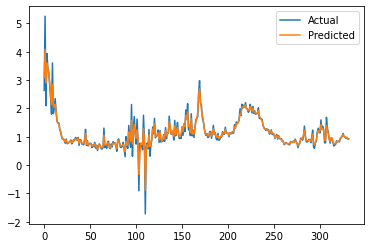

In [129]:
plt.plot(y_train.values, label = 'Actual')
plt.plot(model.predict(X_train), label = 'Predicted')
plt.legend()

### Testing data plot

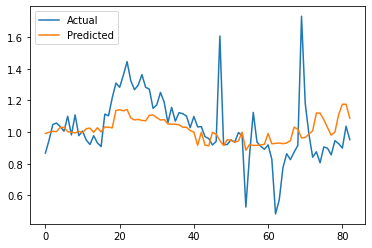

In [130]:
plt.plot(y_test.values, label = 'Actual')
plt.plot(y_pred, label = 'Predicted')
plt.legend()

### Conclusion
As we can see from the above graph, simply traing the model and expecting it to perform well long term is not feasible. To combat this, we try to have dynamic predictions for each day. We train a fresh model each day based on past data, to predict the percentage change in new cases 7 days from now, compared to today.

### Dynamic RandomForestRegressor


In [131]:
percentage_training_data = 0.8
y_test = Y[int(len(Y) * percentage_training_data):].fillna(1).replace(np.inf, 50)
y_pred = []
for date in X[int(len(X) * percentage_training_data):].index:
  X_train = X.loc[:date][:-1]
  y_train = Y.loc[:date][:-1].fillna(1).replace(np.inf, 50)
  X_test = X.loc[date]
  
  sel = SelectKBest(score_func = mutual_info_regression, k = 15)
  sel = sel.fit(X_train, y_train)
  X_train = sel.transform(X_train)
  X_test = sel.transform([X_test])

  model = RandomForestRegressor(n_estimators = 200, n_jobs = -1)
  model = model.fit(X_train, y_train)
  y_pred.append(model.predict(X_test)[0])


In [132]:
metrics.mean_squared_error(y_test, y_pred)

0.029494971808196553

### Predicted data plot

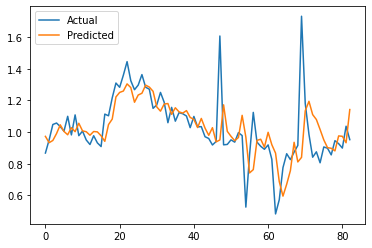

In [133]:
plt.plot(y_test.values, label = 'Actual')
plt.plot(y_pred, label = 'Predicted')
plt.legend()

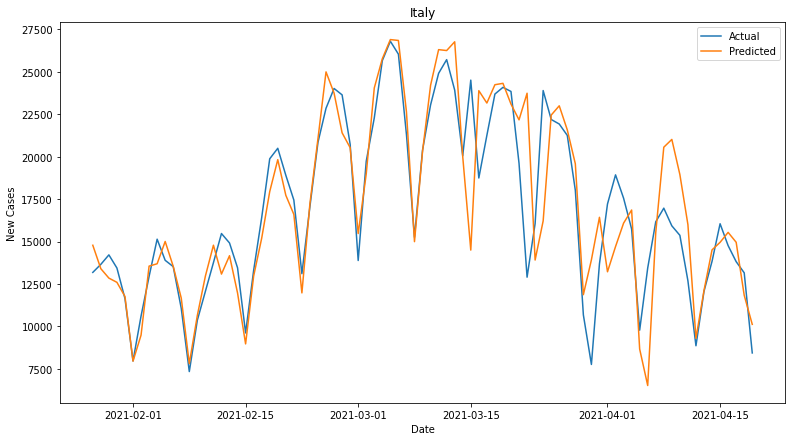

In [134]:
plt.subplots(figsize=(13,7))
plt.title(country)
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.plot((X[int(len(X) * percentage_training_data):]['new_cases']) * y_test.values, label = 'Actual')
plt.plot((X[int(len(X) * percentage_training_data):]['new_cases']) * y_pred, label = 'Predicted')
plt.legend()

In [135]:
(data['new_cases'] < 0).any()

True

### Conclusion
As we can see from the above graph, the predicted data lags the actual data. This means that the model simply predicts what it encounters now, rendering the result unuseable.